In [1]:
#standard kaggle placeholder code

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/automated-medical-diagnosis-using-clinical-notes/clinical_notes_dataset.csv
/kaggle/input/prescriptionbasedprediction/roam_prescription_based_prediction.jsonl


Import modules

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import warnings
warnings.filterwarnings('ignore')

import random
import albumentations as A

# add as needed

In [9]:
# Load data
data_path = '/kaggle/input/automated-medical-diagnosis-using-clinical-notes/clinical_notes_dataset.csv'

df = pd.read_csv(data_path)

df.head()

,Patient_ID,Age,Gender,Primary_Complaint,Additional_Symptoms,Previous_Diagnoses,Medications,Family_History,Lifestyle_Factors,Diagnosis_Suggestion
0,PID_1,33,Other,Abdominal pain,Joint pain,NaN,Aspirin,Heart disease,Smoker,Possible Migraine
1,PID_2,65,Female,Fatigue,Joint pain,NaN,Amoxicillin,Diabetes,Smoker,Likely Hypertension
2,PID_3,32,Male,Fatigue,Joint pain,Hypertension,Amoxicillin,Diabetes,Moderate Drinker,Suspected Diabetes
3,PID_4,38,Female,Cough,NaN,Hypertension,NaN,Hypertension,Non-Smoker,Possible Infection
4,PID_5,23,Male,Headache,NaN,Hypertension,Amoxicillin,NaN,Non-Smoker,Suspected Diabetes


* 3000 rows - a good number
* 10 columns - mostly categorical, one numerical, label seems free form text

In [5]:
df.Diagnosis_Suggestion.value_counts()

Diagnosis_Suggestion
Likely Hypertension       628
Further Tests Required    626
Possible Migraine         615
Suspected Diabetes        570
Possible Infection        561
Name: count, dtype: int64

* Actually the label field is categorical, not free text
* This can be used in classical ML too
* We would look at all the fields

In [7]:
df.describe(include='all')

,Patient_ID,Age,Gender,Primary_Complaint,Additional_Symptoms,Previous_Diagnoses,Medications,Family_History,Lifestyle_Factors,Diagnosis_Suggestion
count,3000,3000.000000,3000,3000,2510,2407,2384,2385,3000,3000
unique,3000,NaN,3,5,5,4,4,4,5,5
top,PID_1,NaN,Female,Fatigue,Fever,Hypertension,Metformin,Diabetes,Non-Smoker,Likely Hypertension
freq,1,NaN,1034,649,520,638,644,632,620,628
mean,NaN,54.655333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,20.256159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,37.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,54.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,73.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Data seems quite clean
* All required coulmns are complete
* Interestingly most features are categorial - easier to pre-process
* Patients are all adults - with a reasonably uniform distribution between 20 and 89
* We can make some pairwise comparisons

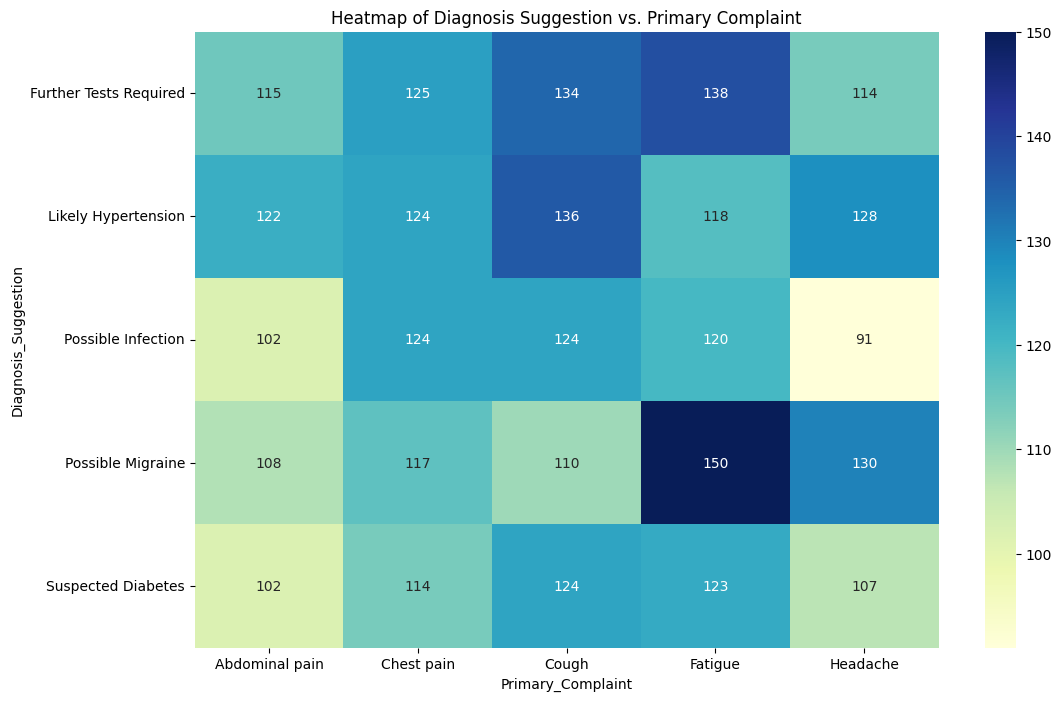

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame loaded from the Kaggle dataset
# Create a crosstab to count the occurrences
crosstab_complaint = pd.crosstab(df['Diagnosis_Suggestion'], df['Primary_Complaint'])

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    crosstab_complaint, 
    annot=True,     # Show the counts in each cell
    fmt='d',        # Format as integer
    cmap='YlGnBu'   # Use a color-blind friendly palette
)
plt.title('Heatmap of Diagnosis Suggestion vs. Primary Complaint')
plt.show()


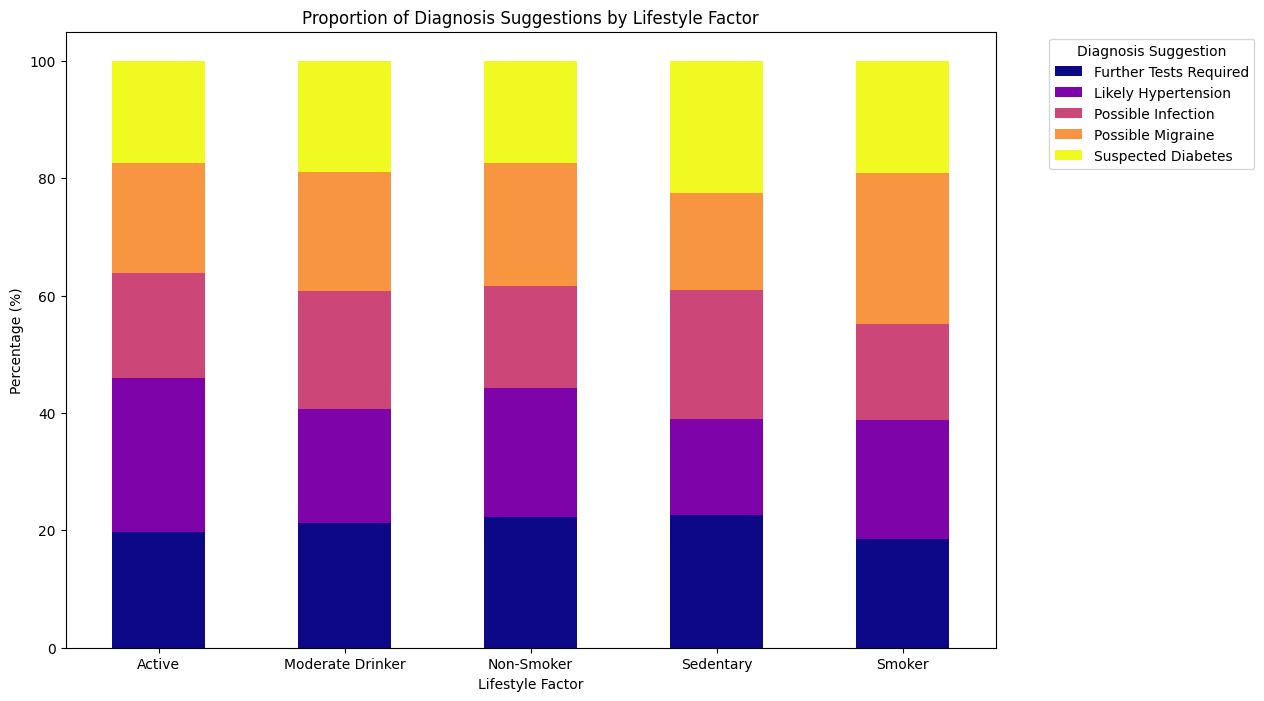

In [14]:
# crosstab of Lifestyle_Factors and Diagnosis_Suggestion
crosstab_lifestyle = pd.crosstab(df['Lifestyle_Factors'], df['Diagnosis_Suggestion'])

# Calculate the percentage for the stacked chart
ct_percentage = crosstab_lifestyle.apply(lambda x: x / x.sum() * 100, axis=1)

# Plot the 100% stacked bar chart
ct_percentage.plot(
    kind='bar', 
    stacked=True, 
    figsize=(12, 8), 
    colormap='plasma'
)

plt.title('Proportion of Diagnosis Suggestions by Lifestyle Factor')
plt.xlabel('Lifestyle Factor')
plt.ylabel('Percentage (%)')
plt.legend(title='Diagnosis Suggestion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()


<Figure size 1200x800 with 0 Axes>

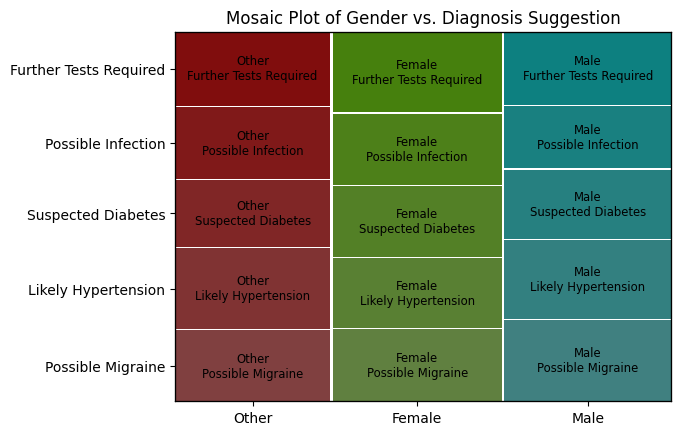

In [15]:
# obvious compare - gender and diagnostics

from statsmodels.graphics.mosaicplot import mosaic

# Create the mosaic plot
plt.figure(figsize=(12, 8))
mosaic(df, ['Gender', 'Diagnosis_Suggestion'], title='Mosaic Plot of Gender vs. Diagnosis Suggestion')
plt.show()


In [17]:
# for age, first create bins...
import pandas as pd


# Bins will be [20, 30, 40, 50, 60, 70, 80, 90, 100]
bins = list(range(20, 101, 10)) 

labels = [f'{i}s' for i in bins[:-1]]


df['AgeGroup'] = pd.cut(
    df['Age'], 
    bins=bins, 
    labels=labels, 
    right=False,        # left edge - 20, 30, etc. 
    include_lowest=True) 

print(df[['Age', 'AgeGroup']].head())


   Age AgeGroup
0   33      30s
1   65      60s
2   32      30s
3   38      30s
4   23      20s


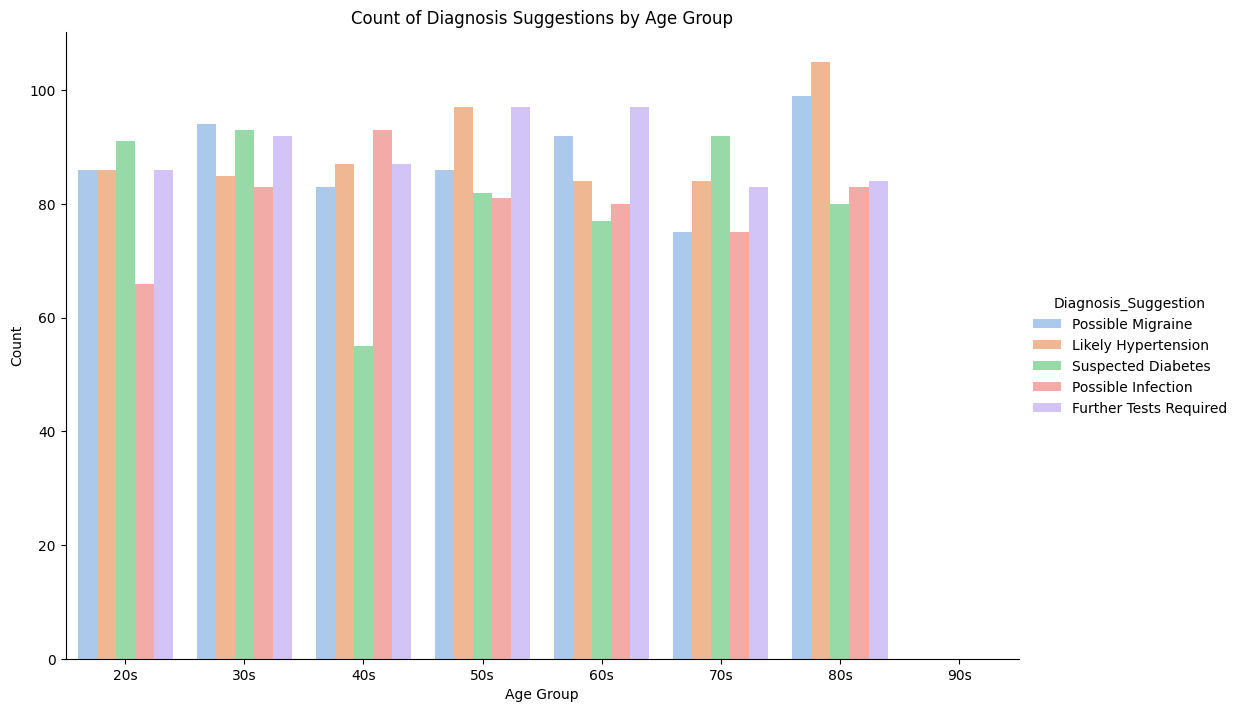

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# compare age and suggestion

sns.catplot(
    data=df,
    x='AgeGroup',  # <-- Use the new categorical column here
    hue='Diagnosis_Suggestion',
    kind='count',
    height=7,
    aspect=1.5,
    palette='pastel'
)
plt.title('Count of Diagnosis Suggestions by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()
